In [49]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "drive/MyDrive/SIFT"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/SIFT'
/content/drive/MyDrive/SIFT


In [50]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# read images
img1 = cv.imread('pickaxe_with_bg.png') # works quite good
#img1 = cv.imread('dirt_with_bg.png') # doesn't work so good (hard to differentiate from other blocks and also multiple slots are filled with dirt)
img2 = cv.imread('inventory_fg.png')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

In [51]:
#sift
sift = cv.xfeatures2d.SIFT_create(nfeatures=1000)

keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

#feature matching
bf = cv.BFMatcher.create()
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x: x.distance)

In [52]:
#distances = list(map(lambda match: match.distance, matches))
#average_distance = sum(distances)/len(distances)
#plt.plot(distances)
#plt.title("Match distances")
#plt.axhline(y=average_distance, color="red", linestyle="--")

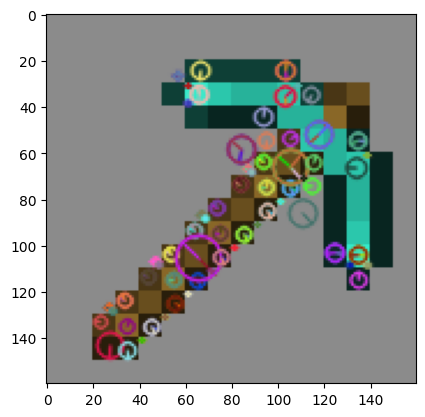

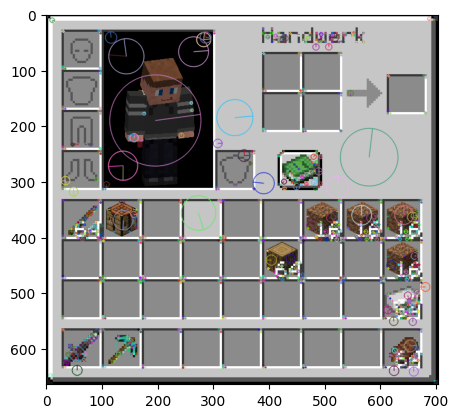

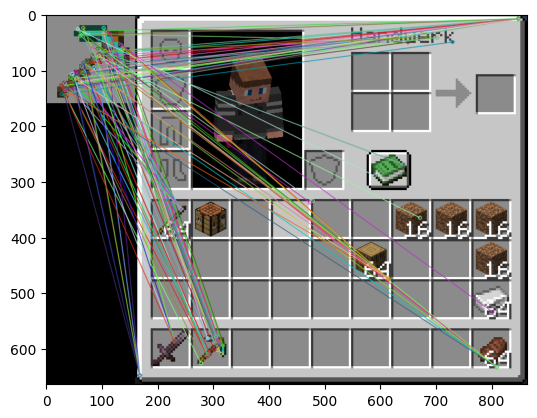

In [53]:
plt.imshow(cv.drawKeypoints(img1, keypoints1, None, flags=4))
plt.savefig("plotsSift/keypointsPickaxe.png", bbox_inches="tight")
plt.show()
plt.imshow(cv.drawKeypoints(img2, keypoints2, None, flags=4))
plt.savefig("plotsSift/keypointsInventory.png", bbox_inches="tight")
plt.show()
plt.imshow(cv.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=2))
plt.savefig("plotsSift/matches.png", bbox_inches="tight")
plt.show()

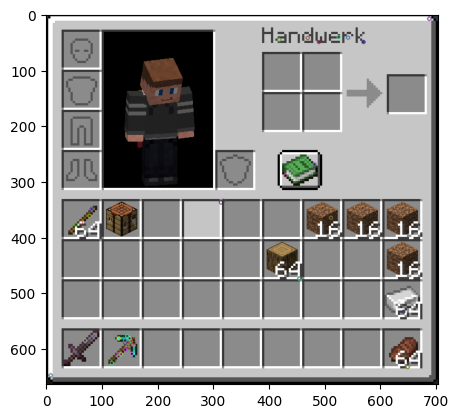

In [54]:
keypoints = []
for match in matches:
  keypoints.append(keypoints2[match.trainIdx])
plt.imshow(cv.drawKeypoints(img2, keypoints, None, flags=0))
plt.savefig("plotsSift/matchedKeypoints.png", bbox_inches="tight")
plt.show()

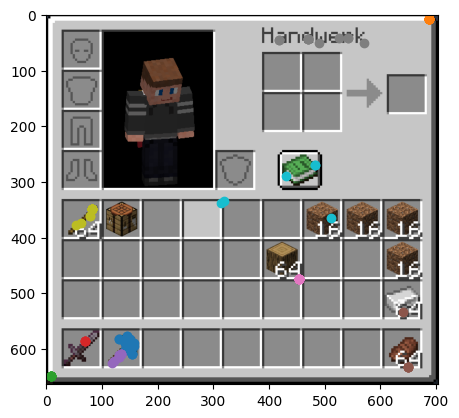

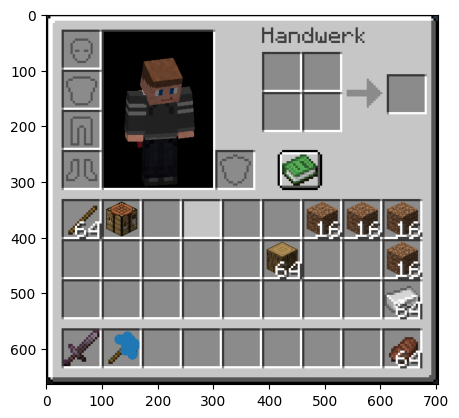

In [55]:
coords = np.array(list(map(lambda point: point.pt, keypoints)), dtype=np.float32)
k = 10 # maybe k >= count of inventory slots and then merge close clusters together?

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(coords, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

clusters = []
for i in range(k):
  clusters.append(coords[label.ravel()==i])

plt.imshow(img2)
for cluster in clusters:
  plt.scatter(cluster[:,0], cluster[:,1])
plt.savefig("plotsSift/clusteredKeypoints.png", bbox_inches="tight")
plt.show()

clusters_new = []
for cluster in clusters:
  # filter out small clusters, this parameter really depends on how good the texture was found. (E.g. pickaxe_with_bg.png vs pickaxe_same_size_with_bg.png) Solution: merge close clusters
  if len(cluster) >= 20: # good params: 20 for pickaxe_with_bg.png and 15 for pickaxe_same_size_with_bg.png
    clusters_new.append(cluster)
clusters = clusters_new


plt.imshow(img2)
for cluster in clusters:
  plt.scatter(cluster[:,0], cluster[:,1])
plt.savefig("plotsSift/clusteredKeypointsFiltered.png", bbox_inches="tight")
plt.show()

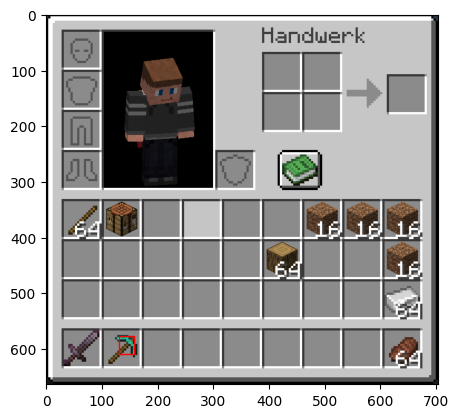

In [56]:
import matplotlib.patches as patches

plt.imshow(img2)
for cluster in clusters:
  min_x = min(cluster[:,0])
  max_x = max(cluster[:,0])
  min_y = min(cluster[:,1])
  max_y = max(cluster[:,1])
  rect = patches.Rectangle((min_x, min_y), max_x-min_x, max_y-min_y, linewidth=1, edgecolor='r', facecolor='none')
  plt.gca().add_patch(rect)
plt.savefig("plotsSift/boundingboxes.png", bbox_inches="tight")
plt.show()

# Results

*   Seems to work best when the texture that is searched also contains the inventory background
*   Achieves way better results if the searched texture has the same size as in the inventory image
  * SIFT scales with a gaussian blur mask, so the textures get blurred and therefore don't get recognized anymore
  * Solution: Scale the textures to a reasonable size with nearest-neighbour-scaling
* Dirt block texture achieves not so good results compared to the pickaxe texture, because:
  * All blocks have the same outline in the menus
  * Dirt block appears multiple times in the crafting table
* Sometimes the lower keypoints of the pickaxe texture get matched with the stick in the inventory and the rest of the keypoints get properly matched with the pickaxe in the inventory. This leads to a smaller bounding box around the pickaxe
  * Solution (for this and the problem of multiple items in the inventory): Let the keypoints of the texture be matched with multiple keypoints of the inventory
* SIFT converts RGB to grayscale images. This could be problematic for identifying different types of tools (iron vs gold vs diamond vs ...)
  * Possible solution: first use sift, then compare difference of cropped section with searched texture